In [29]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
import h2o
from h2o.automl import H2OAutoML
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics as mt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import sys

np.random.seed(1326)
pd.set_option("display.max_columns", None)

# Load and Prep Data

In [2]:
df = pd.read_csv("../datasets/full_dataset.csv")

display(df.info())
display(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366780 entries, 0 to 3366779
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Date                     object 
 1   Lat                      float64
 2   Long                     float64
 3   Total Rainfall Today     float64
 4   Rainfall Duration Today  int64  
 5   Year                     int64  
 6   Department               object 
 7   Municipality             object 
 8   elevation                float64
 9   Forest Loss %            float64
 10  Landslide                int64  
 11  Soil_1                   float64
 12  Soil_2                   float64
 13  Soil_3                   float64
 14  Soil_4                   float64
dtypes: float64(9), int64(3), object(3)
memory usage: 385.3+ MB


None

,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4
count,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06,3.366780e+06
mean,5.573825e+00,-7.462040e+01,6.243005e+00,1.044881e+01,2.013841e+03,1.187612e+03,1.573769e-02,1.109963e-03,4.084843e+00,-7.461016e-01,4.562366e-01,1.110801e-01
std,2.569085e+00,1.689264e+00,9.998163e+00,8.416881e+00,2.503658e+00,9.354618e+02,1.879404e-02,3.329761e-02,4.177085e+01,1.915195e+01,1.272373e+01,9.126118e+00
min,-4.203165e+00,-8.171853e+01,0.000000e+00,0.000000e+00,2.010000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.171196e+02,-6.746594e+01,-7.011410e+01,-4.438806e+01
25%,4.271262e+00,-7.574878e+01,4.000000e-01,2.000000e+00,2.012000e+03,2.170473e+02,3.813281e-03,0.000000e+00,-2.638596e+01,-1.290731e+01,-6.179237e+00,-4.827454e+00
50%,5.518121e+00,-7.474952e+01,2.800000e+00,1.000000e+01,2.014000e+03,1.191456e+03,9.318864e-03,0.000000e+00,4.413120e+00,-1.126930e+00,6.753207e-01,-1.692138e-01
75%,6.878518e+00,-7.342148e+01,8.300000e+00,1.700000e+01,2.016000e+03,1.915797e+03,2.023064e-02,0.000000e+00,3.199778e+01,1.130512e+01,7.533709e+00,4.624294e+00
max,1.338142e+01,-6.704646e+01,3.723000e+02,2.400000e+01,2.018000e+03,3.670899e+03,1.782083e-01,1.000000e+00,1.575212e+02,7.973027e+01,4.976447e+01,7.451414e+01


,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4
0,2010-01-01,-4.203165,-69.935907,0.4,4,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
1,2010-01-02,-4.203165,-69.935907,0.0,0,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
2,2010-01-03,-4.203165,-69.935907,1.6,11,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
3,2010-01-04,-4.203165,-69.935907,6.7,17,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
4,2010-01-05,-4.203165,-69.935907,24.9,24,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366775,2017-12-27,13.381425,-81.365743,1.6,13,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3366776,2017-12-28,13.381425,-81.365743,6.2,23,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3366777,2017-12-29,13.381425,-81.365743,9.9,23,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3366778,2017-12-30,13.381425,-81.365743,2.6,17,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076


## Rainfall Lag

In [3]:
RAINFALL_LAG_TERM = 7

df["Total Rainfall Lag"] = (
    df.groupby(["Lat", "Long"])["Total Rainfall Today"]
        .transform(lambda x: x.rolling(5).sum().shift())
        .fillna(0)
)
df["Rainfall Duration Lag"] = (
    df.groupby(["Lat", "Long"])["Rainfall Duration Today"]
        .transform(lambda x: x.rolling(5).sum().shift())
        .fillna(0)
)

df[["Total Rainfall Lag", "Rainfall Duration Lag"]].describe()

,Total Rainfall Lag,Rainfall Duration Lag
count,3.366780e+06,3.366780e+06
mean,3.118593e+01,5.221549e+01
std,3.391097e+01,3.379563e+01
min,0.000000e+00,0.000000e+00
25%,8.100000e+00,2.100000e+01
50%,2.260000e+01,5.300000e+01
75%,4.330000e+01,7.900000e+01
max,6.229000e+02,1.200000e+02


## Subset Data

In [4]:
df_landslide = df[df["Landslide"] == 1]
df_nolandslide = df[df["Landslide"] == 0]

num_landslides = len(df_landslide)
total_records = 100000

if total_records is None:
    df_sample = df.copy()
elif total_records >= num_landslides * 2:
    df_nolandslide = df_nolandslide.sample(n = total_records - num_landslides, random_state = 1326)
    df_sample = pd.concat([ df_landslide, df_nolandslide ], ignore_index = False)
else:
    raise Exception("{} is not enough records for {} landslides".format(total_records, num_landslides))

display(df_sample.describe())
pd.Series.value_counts(df_sample["Landslide"], normalize = True)

,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,5.542024,-74.645201,6.383668,10.584640,2013.798780,1199.464094,0.015574,0.037370,4.354013,-0.692460,0.523374,0.121330,31.584623,52.76647
std,2.557748,1.687432,10.188880,8.452452,2.506853,932.805385,0.018671,0.189668,41.748955,19.154815,12.740145,9.064807,33.895760,34.06370
min,-4.203165,-81.718525,0.000000,0.000000,2010.000000,0.000000,0.000000,0.000000,-117.119598,-67.465938,-70.114099,-44.388061,0.000000,0.00000
25%,4.245270,-75.767345,0.400000,2.000000,2012.000000,228.253155,0.003756,0.000000,-26.018959,-12.816896,-6.084813,-4.854323,8.400000,21.00000
50%,5.491592,-74.772305,2.900000,10.000000,2014.000000,1218.962402,0.009202,0.000000,4.574126,-1.018664,0.737385,-0.111609,23.300000,54.00000
75%,6.817226,-73.443175,8.500000,17.000000,2016.000000,1916.774292,0.019945,0.000000,32.132043,11.381635,7.566346,4.624294,44.100000,80.00000
max,13.381425,-67.046459,317.500000,24.000000,2018.000000,3670.898682,0.178208,1.000000,157.521167,79.730275,49.764472,74.514142,539.300000,120.00000


Landslide
0    0.96263
1    0.03737
Name: proportion, dtype: float64

## Finalize Data

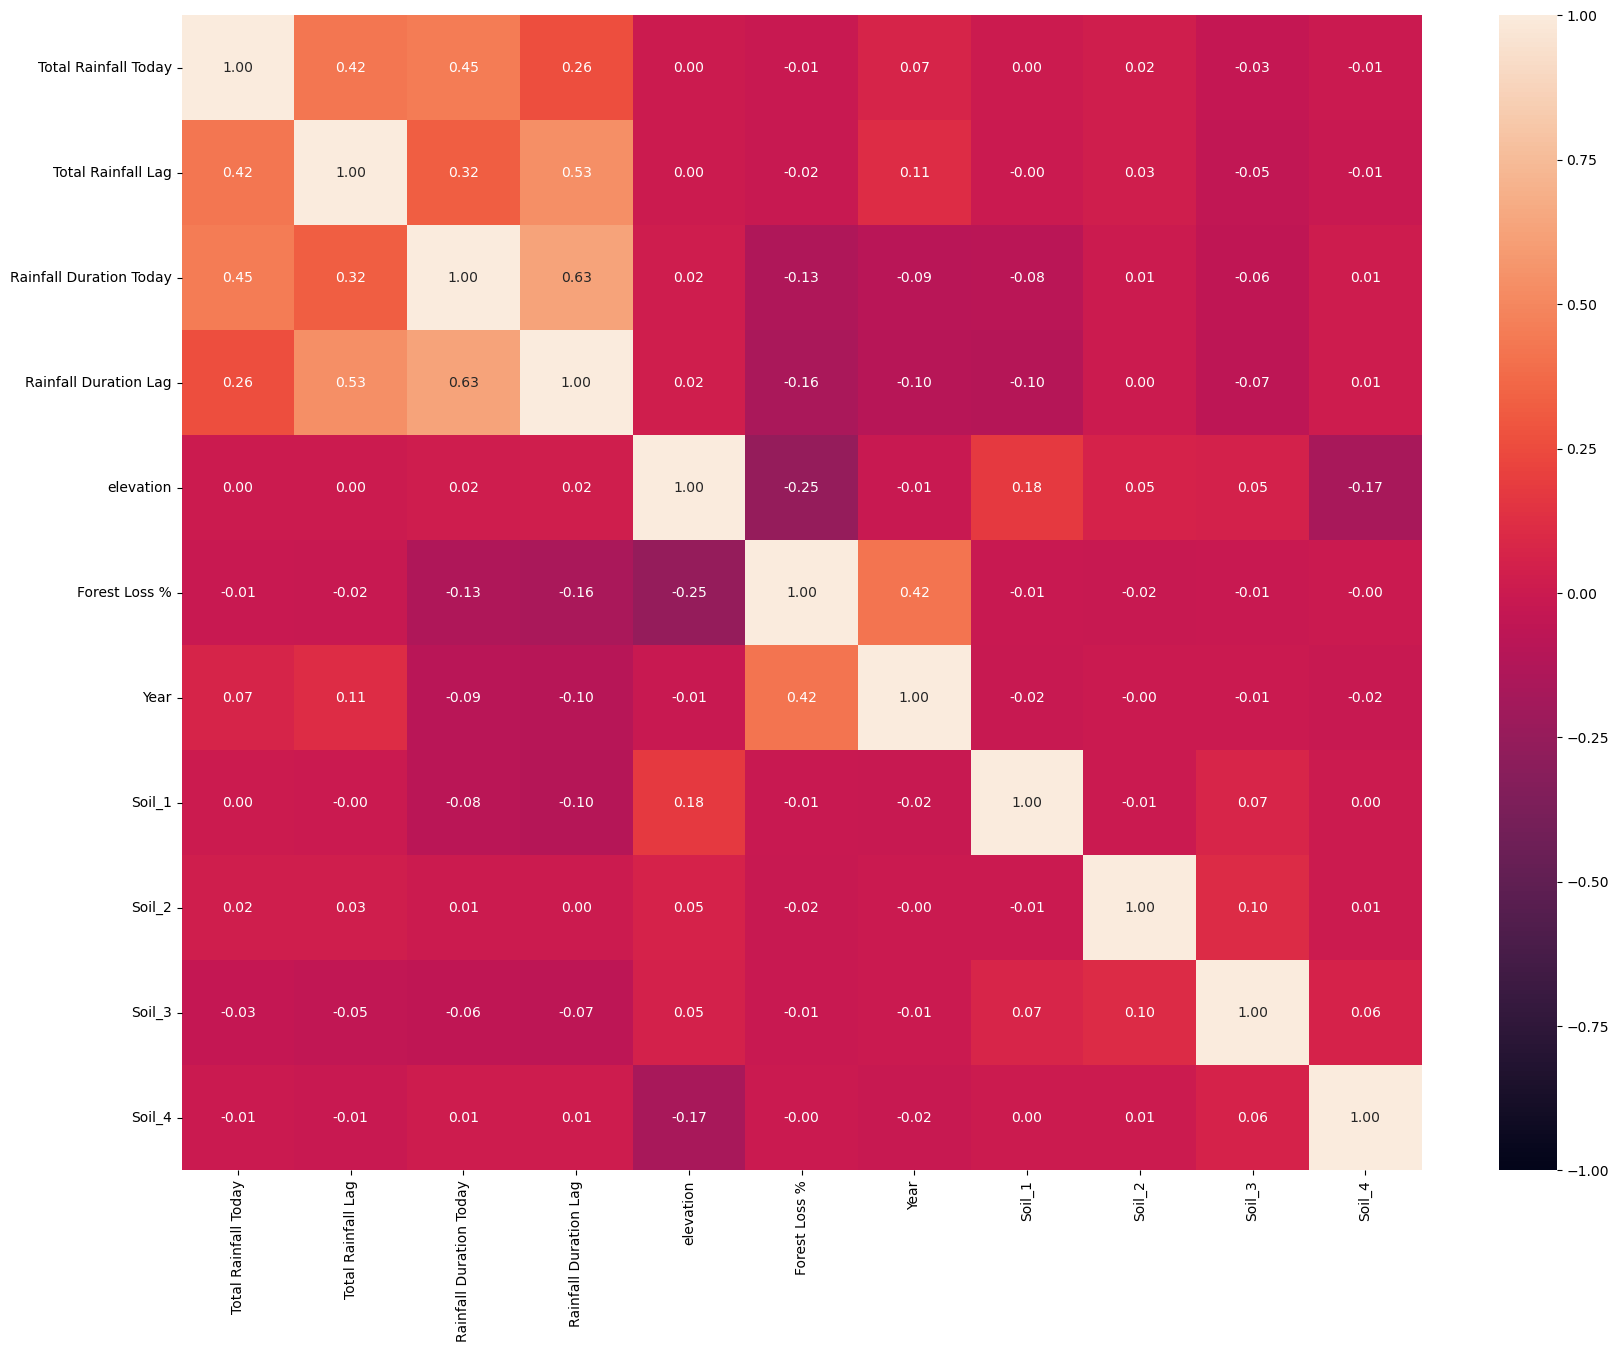

In [5]:
feature_cols = [
    "Total Rainfall Today", "Total Rainfall Lag", "Rainfall Duration Today", "Rainfall Duration Lag",
    "elevation", "Forest Loss %", "Year",
    "Soil_1", "Soil_2", "Soil_3", "Soil_4"
]
outcome_col = "Landslide"

df_features = df_sample[feature_cols]

plt.figure(figsize = (20, 15))
sns.heatmap(df_features.corr(), annot=True, fmt=".2f", vmin = -1, vmax = 1)

plt.show()

In [6]:
df_features[outcome_col] = df_sample[outcome_col]

df_train, df_test = train_test_split(df_features, train_size = 0.8, random_state = 1326, stratify = df_features[outcome_col])
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

print("Training Size:", df_train.shape)
print("Testing Size:", df_test.shape)
print()
print("Training Class Balance:", df_train[outcome_col].value_counts(normalize = True), sep = "\n")
print("Testing Class Balance:", df_test[outcome_col].value_counts(normalize = True), sep = "\n")

Training Size: (80000, 12)
Testing Size: (20000, 12)

Training Class Balance:
Landslide
0    0.962625
1    0.037375
Name: proportion, dtype: float64
Testing Class Balance:
Landslide
0    0.96265
1    0.03735
Name: proportion, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols].to_numpy())
df_test[feature_cols] = scaler.transform(df_test[feature_cols].to_numpy())

In [82]:
class_weights = compute_class_weight(
    "balanced", classes = np.unique(df_train[outcome_col]), y = df_train[outcome_col]
)
df_train_weighted = df_train.copy()
df_train_weighted["Weight"] = df_train_weighted[outcome_col].map({ 0: class_weights[0], 1: class_weights[1] })
df_train_weighted

,Total Rainfall Today,Total Rainfall Lag,Rainfall Duration Today,Rainfall Duration Lag,elevation,Forest Loss %,Year,Soil_1,Soil_2,Soil_3,Soil_4,Landslide,Weight
0,-0.585412,0.032227,-0.777974,0.358044,1.376923,-0.770424,-1.117082,0.012784,-0.337575,-0.561264,-1.402816,0,0.519413
1,0.739826,0.814673,1.585728,1.178768,-0.383039,-0.326656,0.479669,1.520782,-0.170245,-0.295870,-0.098037,1,13.377926
2,-0.624389,-0.912613,-1.250715,-1.517895,0.217843,-0.189396,-0.318706,0.014163,0.760991,0.196860,1.194656,0,0.519413
3,-0.595156,-0.894898,-1.132530,-1.283403,0.424694,-0.249976,-1.516269,2.185788,0.858582,0.650973,-0.729046,0,0.519413
4,0.086952,0.711331,1.585728,1.852934,-0.324563,-0.607264,-0.318706,-0.455882,0.480577,0.402444,-0.275269,0,0.519413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1.850688,-0.351614,1.585728,1.237391,-1.186102,-0.678648,-0.318706,-1.509161,-0.279553,-0.586597,-1.259194,0,0.519413
79996,0.194140,-0.581919,0.049322,-0.433368,-1.284004,0.053153,1.677232,-1.994480,0.912797,-0.192843,-0.491300,0,0.519413
79997,-0.575667,0.333395,-0.659789,1.530507,0.820680,-0.370758,-0.717894,0.643511,0.249379,2.178987,-0.593726,0,0.519413
79998,1.178324,0.359969,0.758432,0.182175,-0.284256,-0.192169,-0.717894,0.171014,0.833131,-1.370778,-1.754953,0,0.519413


In [9]:
rus = RandomUnderSampler(random_state = 1326)

X_rus, y_rus = rus.fit_resample(df_train[feature_cols].to_numpy(), df_train[outcome_col].to_numpy())
df_train_rus = pd.DataFrame()
df_train_rus[feature_cols] = X_rus
df_train_rus[outcome_col] = y_rus
df_train_rus

,Total Rainfall Today,Total Rainfall Lag,Rainfall Duration Today,Rainfall Duration Lag,elevation,Forest Loss %,Year,Soil_1,Soil_2,Soil_3,Soil_4,Landslide
0,-0.624389,-0.818129,-1.250715,-1.312715,-0.855371,-0.197138,-1.117082,-0.511755,2.753323,1.464271,-0.427340,0
1,1.051647,0.014511,1.585728,1.090833,-0.080467,-0.757781,-1.117082,-1.068561,-0.053344,-0.359287,0.209605,0
2,0.252607,0.392448,1.585728,1.970180,-1.232103,-0.777858,-1.117082,0.584762,-0.225990,-1.055460,1.245911,0
3,-0.624389,-0.747266,-1.250715,-1.195468,0.007623,-0.227274,-1.117082,-1.463569,-0.656256,0.220984,-0.152835,0
4,-0.624389,-0.874229,-1.250715,-0.960976,-1.049287,0.793210,-0.717894,-1.091613,-0.686163,0.851931,1.688208,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5975,0.184396,0.292058,1.112988,0.387356,-0.242201,0.007501,0.878856,-1.614756,-0.200771,0.657500,0.138100,1
5976,2.328163,1.316620,1.585728,1.002899,0.321146,1.315457,0.878856,1.754296,0.698211,0.411553,0.452776,1
5977,0.466983,0.732000,0.876618,1.823622,1.475171,-0.088963,1.278044,0.595543,0.458043,0.493713,-0.503731,1
5978,-0.322313,0.693615,0.403877,1.354637,-0.058274,-0.309083,-0.318706,-2.156078,2.493129,-0.715021,-1.144462,1


In [10]:
smote = SMOTE(random_state = 1326)

X_smote, y_smote = smote.fit_resample(df_train[feature_cols].to_numpy(), df_train[outcome_col].to_numpy())
df_train_smote = pd.DataFrame()
df_train_smote[feature_cols] = X_smote
df_train_smote[outcome_col] = y_smote
df_train_smote

,Total Rainfall Today,Total Rainfall Lag,Rainfall Duration Today,Rainfall Duration Lag,elevation,Forest Loss %,Year,Soil_1,Soil_2,Soil_3,Soil_4,Landslide
0,-0.585412,0.032227,-0.777974,0.358044,1.376923,-0.770424,-1.117082,0.012784,-0.337575,-0.561264,-1.402816,0
1,0.739826,0.814673,1.585728,1.178768,-0.383039,-0.326656,0.479669,1.520782,-0.170245,-0.295870,-0.098037,1
2,-0.624389,-0.912613,-1.250715,-1.517895,0.217843,-0.189396,-0.318706,0.014163,0.760991,0.196860,1.194656,0
3,-0.595156,-0.894898,-1.132530,-1.283403,0.424694,-0.249976,-1.516269,2.185788,0.858582,0.650973,-0.729046,0
4,0.086952,0.711331,1.585728,1.852934,-0.324563,-0.607264,-0.318706,-0.455882,0.480577,0.402444,-0.275269,0
...,...,...,...,...,...,...,...,...,...,...,...,...
154015,-0.327352,0.710331,-0.423419,1.833763,0.658360,-0.465755,-0.511468,0.124900,0.525223,-0.050104,0.375211,1
154016,0.828425,0.639272,1.585728,1.344927,1.340752,-0.765382,-1.117082,1.260150,-0.233686,0.129939,-0.877362,1
154017,-0.070321,-0.376975,0.347903,0.180628,-0.643107,-0.366549,-0.483279,0.089957,-1.512959,-0.546329,-0.131738,1
154018,0.121824,0.207286,0.981882,0.244943,0.218318,-0.349078,0.080481,1.069700,-0.445430,-0.300976,0.597772,1


# Modeling

In [11]:
h2o.init()
h2o_train = h2o.H2OFrame(df_train)
h2o_test = h2o.H2OFrame(df_test)

h2o_train[outcome_col] = h2o_train[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_401"; Java(TM) SE Runtime Environment (build 1.8.0_401-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from /Users/ryanschaefer/miniconda3/envs/mlenv/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/24/0bddfjxx3258qzvf6pn5md3c0000gn/T/tmpdxoabseu
  JVM stdout: /var/folders/24/0bddfjxx3258qzvf6pn5md3c0000gn/T/tmpdxoabseu/h2o_ryanschaefer_started_from_python.out
  JVM stderr: /var/folders/24/0bddfjxx3258qzvf6pn5md3c0000gn/T/tmpdxoabseu/h2o_ryanschaefer_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_5t2rbv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.540 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
aml = H2OAutoML(max_models=15, seed=1326)
aml.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train, 
    leaderboard_frame=h2o_test
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/15
# GBM base models (used / total),6/6
# XGBoost base models (used / total),5/5
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [13]:
h2o.save_model(aml.leader, "../models/base", force = True)
# View the AutoML Leaderboard
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20240407_185226,0.858574,0.121633,0.278666,0.314734,0.175994,0.030974,22654,0.030131,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240407_185226,0.857168,0.122171,0.27456,0.320273,0.176273,0.0310722,25031,0.03042,StackedEnsemble
XGBoost_grid_1_AutoML_1_20240407_185226_model_1,0.850632,0.124132,0.262699,0.33938,0.1773,0.0314353,4647,0.007301,XGBoost
GBM_3_AutoML_1_20240407_185226,0.84876,0.124995,0.255035,0.350794,0.177806,0.0316149,3002,0.01857,GBM
GBM_1_AutoML_1_20240407_185226,0.848075,0.124593,0.264102,0.332431,0.177247,0.0314166,2573,0.021363,GBM
GBM_2_AutoML_1_20240407_185226,0.846153,0.125506,0.251616,0.35399,0.178083,0.0317135,3448,0.023294,GBM
GBM_grid_1_AutoML_1_20240407_185226_model_1,0.845977,0.125621,0.25682,0.349129,0.177636,0.0315545,1506,0.014581,GBM
XGBoost_3_AutoML_1_20240407_185226,0.845355,0.124423,0.265436,0.335936,0.176978,0.0313212,3556,0.005708,XGBoost
GBM_4_AutoML_1_20240407_185226,0.842738,0.125839,0.258207,0.332497,0.177781,0.031606,1661,0.017907,GBM
GBM_5_AutoML_1_20240407_185226,0.839335,0.127078,0.240952,0.332876,0.178753,0.0319528,1888,0.025289,GBM


In [14]:
h2o.init()
h2o_train_smote = h2o.H2OFrame(df_train_smote)
h2o_test = h2o.H2OFrame(df_test)

h2o_train_smote[outcome_col] = h2o_train_smote[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,6 mins 03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_5t2rbv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.389 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
aml_smote = H2OAutoML(max_models=15, seed=1326)
aml_smote.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train_smote, 
    leaderboard_frame=h2o_test
)

AutoML progress: |█████████████████████████████████████████████████████████████Job request failed Unexpected HTTP error: ('Connection aborted.', BadStatusLine('GET /3/Jobs/$03017f00000132d4ffffffff$_82ee8e098b703122bb03592860a744f4 HTTP/1.1\r\n')), will retry after 3s.
██| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/15
# GBM base models (used / total),2/6
# XGBoost base models (used / total),3/5
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [16]:
h2o.save_model(aml_smote.leader, "../models/smote", force = True)
# View the AutoML Leaderboard
lb_smote = h2o.automl.get_leaderboard(aml_smote, extra_columns = "ALL")
lb_smote.head(rows=lb_smote.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_2_20240407_185826,0.843441,0.170883,0.254916,0.329139,0.188106,0.0353837,68824,0.095297,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_2_20240407_185826,0.842264,0.171749,0.253792,0.342854,0.188317,0.0354634,63868,0.084018,StackedEnsemble
GBM_1_AutoML_2_20240407_185826,0.840995,0.133255,0.239698,0.355626,0.18513,0.0342731,14253,0.082436,GBM
GBM_5_AutoML_2_20240407_185826,0.840423,0.140123,0.243774,0.346677,0.189834,0.0360371,17118,0.11695,GBM
GBM_2_AutoML_2_20240407_185826,0.837969,0.137929,0.246822,0.348382,0.188103,0.0353829,14849,0.107306,GBM
GBM_3_AutoML_2_20240407_185826,0.837348,0.135786,0.246009,0.331579,0.186345,0.0347244,13435,0.083092,GBM
GBM_grid_1_AutoML_2_20240407_185826_model_1,0.836081,0.177567,0.2306,0.34986,0.21621,0.0467467,5430,0.029562,GBM
GBM_4_AutoML_2_20240407_185826,0.835836,0.132899,0.242249,0.333773,0.184493,0.0340376,11631,0.064724,GBM
XGBoost_grid_1_AutoML_2_20240407_185826_model_1,0.834377,0.138588,0.242198,0.364682,0.184835,0.034164,78254,0.028981,XGBoost
XGBoost_3_AutoML_2_20240407_185826,0.831924,0.135534,0.235744,0.336606,0.184522,0.0340485,80555,0.027274,XGBoost


In [17]:
h2o.init()
h2o_train_rus = h2o.H2OFrame(df_train_rus)
h2o_test = h2o.H2OFrame(df_test)

h2o_train_rus[outcome_col] = h2o_train_rus[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 39 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_5t2rbv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.220 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [18]:
aml_rus = H2OAutoML(max_models=15, seed=1326)
aml_rus.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train_rus, 
    leaderboard_frame=h2o_test
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),9/15
# GBM base models (used / total),5/6
# XGBoost base models (used / total),4/5
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [19]:
h2o.save_model(aml_rus.leader, "../models/rus", force = True)
# View the AutoML Leaderboard
lb_rus = h2o.automl.get_leaderboard(aml_rus, extra_columns = "ALL")
lb_rus.head(rows=lb_rus.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_3_20240407_203149,0.839566,0.489139,0.221213,0.348031,0.405036,0.164054,3255,0.033438,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_3_20240407_203149,0.839097,0.49167,0.226479,0.353244,0.406799,0.165485,3904,0.02955,StackedEnsemble
GBM_3_AutoML_3_20240407_203149,0.83466,0.5001,0.213886,0.358497,0.410904,0.168842,1123,0.017898,GBM
GBM_4_AutoML_3_20240407_203149,0.831318,0.508694,0.204717,0.393031,0.414746,0.172014,1003,0.013569,GBM
XGBoost_3_AutoML_3_20240407_203149,0.830557,0.507821,0.203583,0.33536,0.41451,0.171819,684,0.003425,XGBoost
GBM_grid_1_AutoML_3_20240407_203149_model_1,0.829557,0.504303,0.206192,0.353034,0.412469,0.170131,553,0.014108,GBM
GBM_5_AutoML_3_20240407_203149,0.828857,0.507953,0.205826,0.33281,0.415157,0.172356,1053,0.016173,GBM
GBM_2_AutoML_3_20240407_203149,0.828175,0.506617,0.204493,0.364805,0.414219,0.171577,1182,0.013005,GBM
GBM_1_AutoML_3_20240407_203149,0.828008,0.508606,0.213266,0.323769,0.414392,0.171721,496,0.016992,GBM
XGBoost_grid_1_AutoML_3_20240407_203149_model_1,0.827506,0.513303,0.197489,0.38978,0.414132,0.171506,526,0.003879,XGBoost


In [20]:
h2o.init()
h2o_train_weighted = h2o.H2OFrame(df_train_weighted)
h2o_test = h2o.H2OFrame(df_test)

h2o_train_weighted[outcome_col] = h2o_train_weighted[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 40 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_5t2rbv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.195 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
aml_weighted = H2OAutoML(max_models=15, seed=1326)
aml_weighted.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train_weighted, 
    leaderboard_frame=h2o_test, weights_column="Weight"
)

AutoML progress: |█████████████████████████████████
20:36:45.373: _weights_column param, All base models use weights_column="Weight" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

██████████████
20:37:11.157: _weights_column param, All base models use weights_column="Weight" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/15
# GBM base models (used / total),2/6
# XGBoost base models (used / total),5/5
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [22]:
h2o.save_model(aml_weighted.leader, "../models/weighted", force = True)
# View the AutoML Leaderboard
lb_weighted = h2o.automl.get_leaderboard(aml_weighted, extra_columns = "ALL")
lb_weighted.head(rows=lb_weighted.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_4_20240407_203253,0.855387,0.122675,0.266665,0.324442,0.176743,0.0312382,24695,0.023273,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_4_20240407_203253,0.854163,0.122842,0.271047,0.336709,0.176704,0.0312244,25334,0.019653,StackedEnsemble
GBM_1_AutoML_4_20240407_203253,0.848682,0.32729,0.265807,0.355037,0.315465,0.0995185,2000,0.013126,GBM
GBM_2_AutoML_4_20240407_203253,0.848098,0.393761,0.247931,0.347061,0.356479,0.127078,4085,0.019379,GBM
GBM_grid_1_AutoML_4_20240407_203253_model_1,0.842959,0.360134,0.243011,0.326811,0.335137,0.112317,1660,0.012327,GBM
GBM_3_AutoML_4_20240407_203253,0.842619,0.385525,0.23718,0.367008,0.351438,0.123509,1646,0.015806,GBM
GBM_4_AutoML_4_20240407_203253,0.841338,0.353,0.232719,0.339531,0.331046,0.109591,2110,0.011291,GBM
XGBoost_grid_1_AutoML_4_20240407_203253_model_1,0.839969,0.294376,0.243279,0.337364,0.303161,0.0919064,2694,0.004744,XGBoost
GBM_5_AutoML_4_20240407_203253,0.839769,0.427199,0.231269,0.335111,0.374875,0.140531,3303,0.018842,GBM
XGBoost_2_AutoML_4_20240407_203253,0.836757,0.275447,0.219471,0.359646,0.292602,0.085616,2466,0.004697,XGBoost


# Evaluate Model Performance

In [72]:
# https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [47]:
h2o.init()

h2o_train = h2o.H2OFrame(df_train)
h2o_test = h2o.H2OFrame(df_test)
h2o_train[outcome_col] = h2o_train[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

aml = h2o.load_model("../models/base/StackedEnsemble_AllModels_1_AutoML_1_20240407_185226")
aml_smote = h2o.load_model("../models/smote/StackedEnsemble_AllModels_1_AutoML_2_20240407_185826")
aml_rus = h2o.load_model("../models/rus/StackedEnsemble_AllModels_1_AutoML_3_20240407_203149")
aml_weighted = h2o.load_model("../models/weighted/StackedEnsemble_AllModels_1_AutoML_4_20240407_203253")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,35 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_wu55n3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.540 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [71]:
df_train_full, df_test_full = train_test_split(df_sample, train_size = 0.8, random_state = 1326, stratify = df_sample[outcome_col])
df_train_full.reset_index(drop = True, inplace = True)
df_test_full.reset_index(drop = True, inplace = True)

df_test_full

,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag
0,2010-12-26,3.175642,-76.259193,2.1,14,2010,Cauca,Corinto,1064.288086,0.001245,0,-26.391287,8.053376,11.208257,-2.664090,28.5,70.0
1,2011-03-25,4.949748,-75.958017,3.0,7,2011,Risaralda,Balboa,1555.228149,0.016442,0,46.948865,16.007244,4.951216,7.941462,22.9,30.0
2,2013-09-01,8.850104,-76.427089,16.4,20,2013,Antioquia,Arboletes,11.107697,0.030439,1,-43.201976,-6.250748,7.306600,2.834127,65.3,103.0
3,2013-06-26,7.347699,-72.945960,0.0,0,2013,Santander,California,2027.564575,0.002748,0,31.572596,2.988497,-2.951173,3.392259,17.4,37.0
4,2014-03-05,3.711138,-73.242014,0.3,3,2014,Meta,San Carlos de Guaroa,223.823059,0.023397,0,-70.451383,-5.681923,-4.433686,-7.187485,39.8,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2012-04-13,6.899482,-73.283678,6.8,20,2012,Santander,Betulia,1816.806152,0.008706,0,1.243489,5.617368,-3.297660,16.222621,59.4,119.0
19996,2015-05-21,6.559299,-75.825540,19.2,5,2015,Antioquia,Santa Fe de Antioquia,573.747009,0.010412,0,24.589466,22.370477,4.780884,5.033322,19.1,10.0
19997,2018-10-15,9.718021,-75.120989,0.0,0,2018,Bolívar,El Carmen de Bolívar,156.749680,0.160509,0,-8.572434,-13.940514,13.818381,5.783892,22.5,67.0
19998,2013-03-06,5.118232,-74.344953,5.3,20,2013,Cundinamarca,Vergara,1535.819092,0.002023,0,-40.307898,-1.713510,-4.028919,2.030330,8.3,58.0


In [73]:
with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    with HiddenPrints():
        df_test_full["Base Probability"] = h2o.as_list(aml.predict(h2o_test)["p1"])
        df_test_full["SMOTE Probability"] = h2o.as_list(aml_smote.predict(h2o_test)["p1"])
        df_test_full["RUS Probability"] = h2o.as_list(aml_rus.predict(h2o_test)["p1"])
        df_test_full["Weighted Probability"] = h2o.as_list(aml_weighted.predict(h2o_test)["p1"])

df_test_full

Test/Validation dataset is missing column 'Weight': substituting in a column of NaN


,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag,Base Probability,SMOTE Probability,RUS Probability,Weighted Probability
0,2010-12-26,3.175642,-76.259193,2.1,14,2010,Cauca,Corinto,1064.288086,0.001245,0,-26.391287,8.053376,11.208257,-2.664090,28.5,70.0,0.038392,4.689180e-03,0.425328,0.038678
1,2011-03-25,4.949748,-75.958017,3.0,7,2011,Risaralda,Balboa,1555.228149,0.016442,0,46.948865,16.007244,4.951216,7.941462,22.9,30.0,0.178388,2.612554e-01,0.867540,0.158179
2,2013-09-01,8.850104,-76.427089,16.4,20,2013,Antioquia,Arboletes,11.107697,0.030439,1,-43.201976,-6.250748,7.306600,2.834127,65.3,103.0,0.009193,1.079373e-04,0.137615,0.011211
3,2013-06-26,7.347699,-72.945960,0.0,0,2013,Santander,California,2027.564575,0.002748,0,31.572596,2.988497,-2.951173,3.392259,17.4,37.0,0.010645,1.381836e-05,0.195621,0.011334
4,2014-03-05,3.711138,-73.242014,0.3,3,2014,Meta,San Carlos de Guaroa,223.823059,0.023397,0,-70.451383,-5.681923,-4.433686,-7.187485,39.8,75.0,0.004071,2.976918e-10,0.147634,0.006306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2012-04-13,6.899482,-73.283678,6.8,20,2012,Santander,Betulia,1816.806152,0.008706,0,1.243489,5.617368,-3.297660,16.222621,59.4,119.0,0.092366,2.070845e-02,0.818328,0.067314
19996,2015-05-21,6.559299,-75.825540,19.2,5,2015,Antioquia,Santa Fe de Antioquia,573.747009,0.010412,0,24.589466,22.370477,4.780884,5.033322,19.1,10.0,0.012065,1.113251e-03,0.317984,0.033513
19997,2018-10-15,9.718021,-75.120989,0.0,0,2018,Bolívar,El Carmen de Bolívar,156.749680,0.160509,0,-8.572434,-13.940514,13.818381,5.783892,22.5,67.0,0.000827,5.946138e-06,0.018866,0.000679
19998,2013-03-06,5.118232,-74.344953,5.3,20,2013,Cundinamarca,Vergara,1535.819092,0.002023,0,-40.307898,-1.713510,-4.028919,2.030330,8.3,58.0,0.016576,1.793877e-04,0.385128,0.012332


In [74]:
model_names = ["Base", "SMOTE", "RUS", "Weighted"]
actual = df_test_full[outcome_col].to_numpy()
beta2 = 4. ** 2
best_thresholds = []

for i, model in enumerate(model_names):
    probs = df_test_full["{} Probability".format(model)].to_numpy()

    ### https://datascience.stackexchange.com/questions/96690/how-to-choose-the-right-threshold-for-binary-classification
    # calculate pr curve
    precision, recall, thresholds = mt.precision_recall_curve(actual, probs)

    # convert to f-beta score
    fscore = ((1 + beta2) * precision * recall) / (beta2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    best_thresholds.append(thresholds[ix])
        
pd.DataFrame({
    "Model": model_names,
    "Threshold": best_thresholds
})

,Model,Threshold
0,Base,0.031815
1,SMOTE,0.004687
2,RUS,0.454767
3,Weighted,0.040845


In [75]:
for i, model in enumerate(model_names):
    probs_col = "{} Probability".format(model)
    preds_col = "{} Prediction".format(model)
    
    df_test_full[preds_col] = (df_test_full[probs_col] > best_thresholds[i]).astype(int)
   
df_test_full.to_csv("../datasets/model_predictions.csv", index = False) 
df_test_full.head()

,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag,Base Probability,SMOTE Probability,RUS Probability,Weighted Probability,Base Prediction,SMOTE Prediction,RUS Prediction,Weighted Prediction
0,2010-12-26,3.175642,-76.259193,2.1,14,2010,Cauca,Corinto,1064.288086,0.001245,0,-26.391287,8.053376,11.208257,-2.664090,28.5,70.0,0.038392,4.689180e-03,0.425328,0.038678,1,1,0,0
1,2011-03-25,4.949748,-75.958017,3.0,7,2011,Risaralda,Balboa,1555.228149,0.016442,0,46.948865,16.007244,4.951216,7.941462,22.9,30.0,0.178388,2.612554e-01,0.867540,0.158179,1,1,1,1
2,2013-09-01,8.850104,-76.427089,16.4,20,2013,Antioquia,Arboletes,11.107697,0.030439,1,-43.201976,-6.250748,7.306600,2.834127,65.3,103.0,0.009193,1.079373e-04,0.137615,0.011211,0,0,0,0
3,2013-06-26,7.347699,-72.945960,0.0,0,2013,Santander,California,2027.564575,0.002748,0,31.572596,2.988497,-2.951173,3.392259,17.4,37.0,0.010645,1.381836e-05,0.195621,0.011334,0,0,0,0
4,2014-03-05,3.711138,-73.242014,0.3,3,2014,Meta,San Carlos de Guaroa,223.823059,0.023397,0,-70.451383,-5.681923,-4.433686,-7.187485,39.8,75.0,0.004071,2.976918e-10,0.147634,0.006306,0,0,0,0


In [76]:
for model in model_names:
    preds = df_test_full["{} Prediction".format(model)]
    print(model)
    print(mt.confusion_matrix(actual, preds))
    print(mt.classification_report(actual, preds))

Base
[[14071  5182]
 [  120   627]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     19253
           1       0.11      0.84      0.19       747

    accuracy                           0.73     20000
   macro avg       0.55      0.79      0.52     20000
weighted avg       0.96      0.73      0.82     20000

SMOTE
[[14704  4549]
 [  164   583]]
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     19253
           1       0.11      0.78      0.20       747

    accuracy                           0.76     20000
   macro avg       0.55      0.77      0.53     20000
weighted avg       0.96      0.76      0.84     20000

RUS
[[13533  5720]
 [  127   620]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     19253
           1       0.10      0.83      0.17       747

    accuracy                           0.71     20000
   macro avg       0

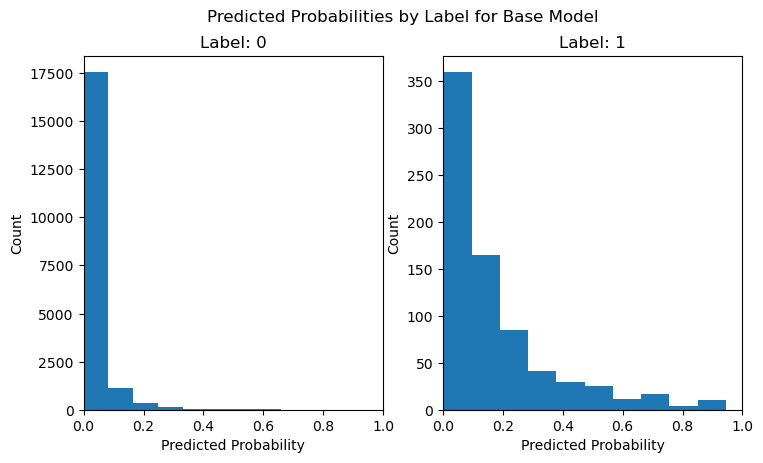

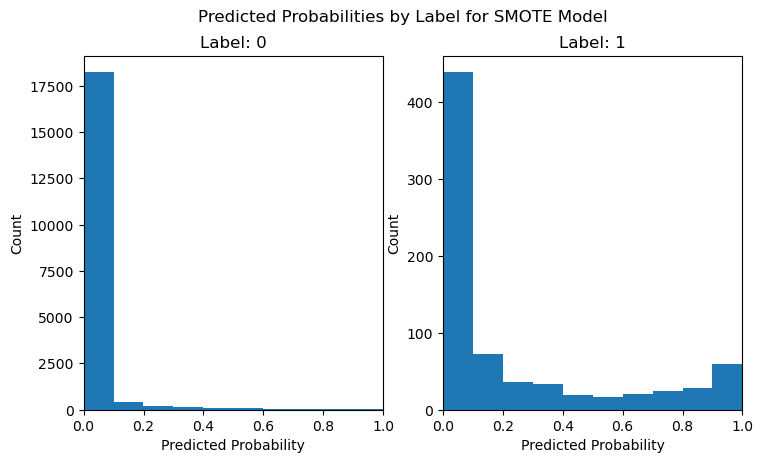

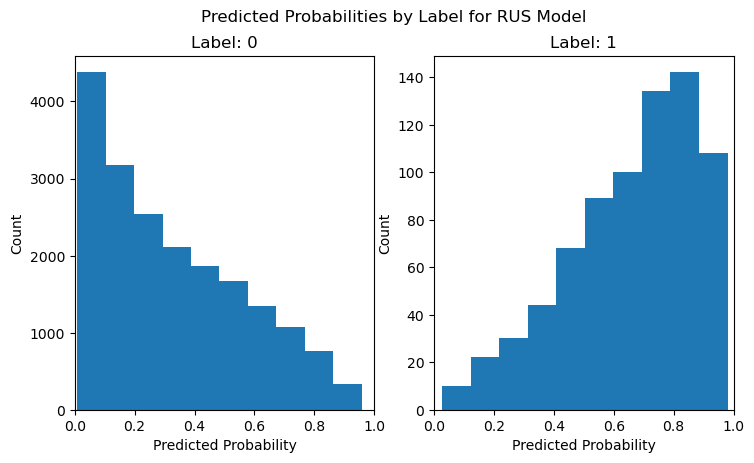

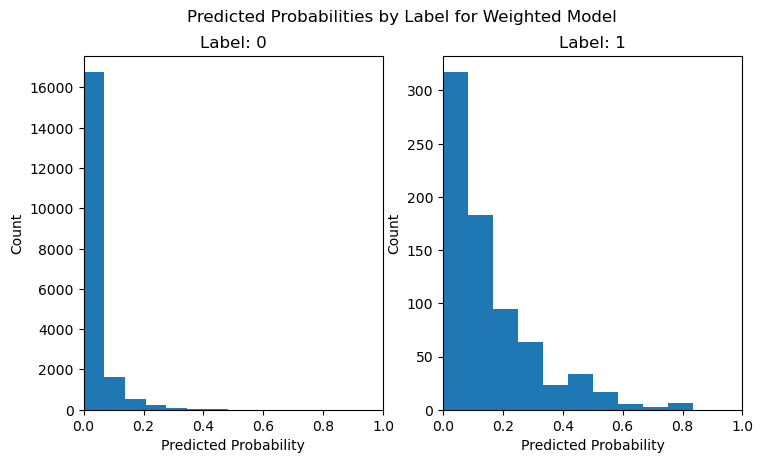

In [77]:
for i, name in enumerate(model_names):
    probs_col = "{} Probability".format(name)
    
    plt.figure(figsize=(1.7 * 5, 2.3 * 2))
    plt.suptitle("Predicted Probabilities by Label for {} Model".format(name))
    for label in [0, 1]:
        df_temp = df_test_full[df_test_full[outcome_col] == label]
        plt.subplot(1, 2, label + 1)
        plt.hist(df_temp[probs_col])
        plt.title("Label: {}".format(label))
        plt.xlim((0, 1))
        plt.xlabel("Predicted Probability")
        plt.ylabel("Count")
        
    plt.show()

In [78]:
class FBeta:
    def __init__(self, beta):
        self.beta = beta
        
    def score(self, y, yhat):
        return mt.fbeta_score(y, yhat, beta = self.beta)

fbeta = FBeta(4)
metrics = {
    "ROC": mt.roc_auc_score,
    "Accuracy": mt.accuracy_score,
    "Balanced Accuracy": mt.balanced_accuracy_score,
    "Precision": mt.precision_score,
    "Recall": mt.recall_score,
    "F1": mt.f1_score,
    "F-Beta": fbeta.score
}
scores = np.zeros((4, 7))
for i, name in enumerate(model_names):
    actual = df_test_full[outcome_col].to_numpy()
    probs = df_test_full["{} Probability".format(name)].to_numpy()
    preds = df_test_full["{} Prediction".format(name)].to_numpy()
    for j, scorer in enumerate(metrics.values()):
        if j == 0:
            scores[(i, j)] = scorer(actual, probs)
        else:
            scores[(i, j)] = scorer(actual, preds)
            
df_scores = pd.DataFrame({
    "Model": model_names
})
df_scores[list(metrics.keys())] = scores

df_scores

,Model,ROC,Accuracy,Balanced Accuracy,Precision,Recall,F1,F-Beta
0,Base,0.858575,0.73490,0.785102,0.107936,0.839357,0.191275,0.600135
1,SMOTE,0.845453,0.76435,0.772090,0.113601,0.780455,0.198333,0.580133
2,RUS,0.839558,0.70765,0.766445,0.097792,0.829987,0.174968,0.576208
3,Weighted,0.855417,0.77255,0.781496,0.118579,0.791165,0.206247,0.593233


# Model Interpretation

In [92]:
class H2OClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_cols, seed = 1, max_models = 10, classifier = None, threshold = 0.5):
        self.feature_cols = feature_cols
        self.seed = seed
        self.max_models = max_models
        self.classifier = classifier
        self.threshold = threshold
        
    def fit(self, X, y):
        X = pd.DataFrame(X, columns = self.feature_cols)
        df = h2o.H2OFrame(X)
        df["Target"] = y
        df["Target"] = df["Target"].asfactor()
        self.classifier = H2OAutoML(seed = self.seed, max_models = self.max_models)
        self.classifier.train(y = "Target", training_frame = y)
        return self
    
    def predict(self, X):
        if self.classifier == None:
            raise Exception("Model not trained")
        
        if self.threshold == None:
            X = pd.DataFrame(X, columns = self.feature_cols)
            df = h2o.H2OFrame(X)
            preds = self.classifier.predict(df)
            with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
                return preds.as_data_frame()["predict"].values
        else:
            return (self.predict_proba(X) > self.threshold).astype(int)
    
    def predict_proba(self, X):
        if self.classifier == None:
            raise Exception("Model not trained")
        X = pd.DataFrame(X, columns = self.feature_cols)
        df = h2o.H2OFrame(X)
        preds = self.classifier.predict(df)
        with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
            return preds.as_data_frame()["p1"].values

In [97]:
with HiddenPrints():
    model = H2OClassifier(feature_cols, classifier = aml, threshold = best_thresholds[0])
    ale = ALE(model.predict_proba, feature_cols)
    exp_train = ale.explain(df_train[feature_cols].to_numpy())
    exp_test = ale.explain(df_test[feature_cols].to_numpy())

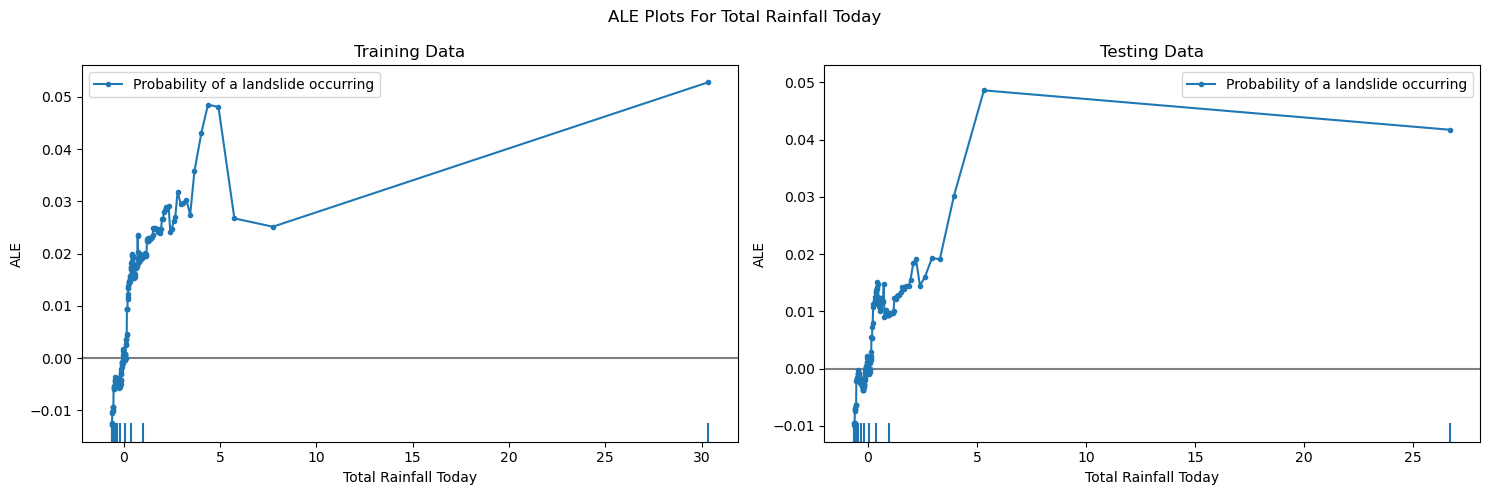

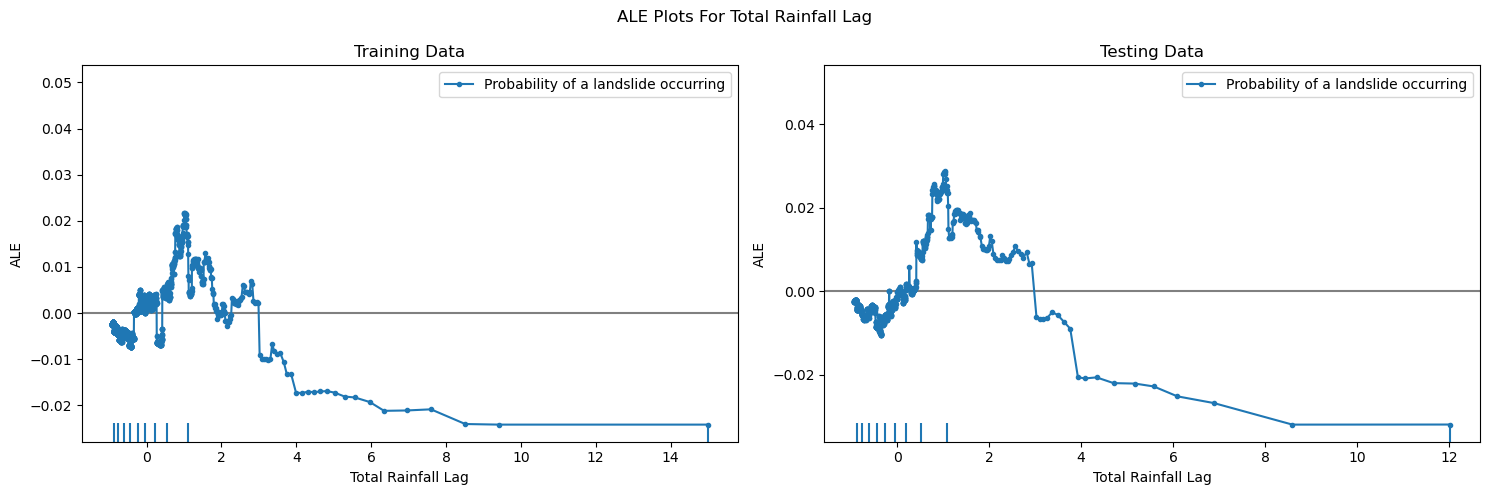

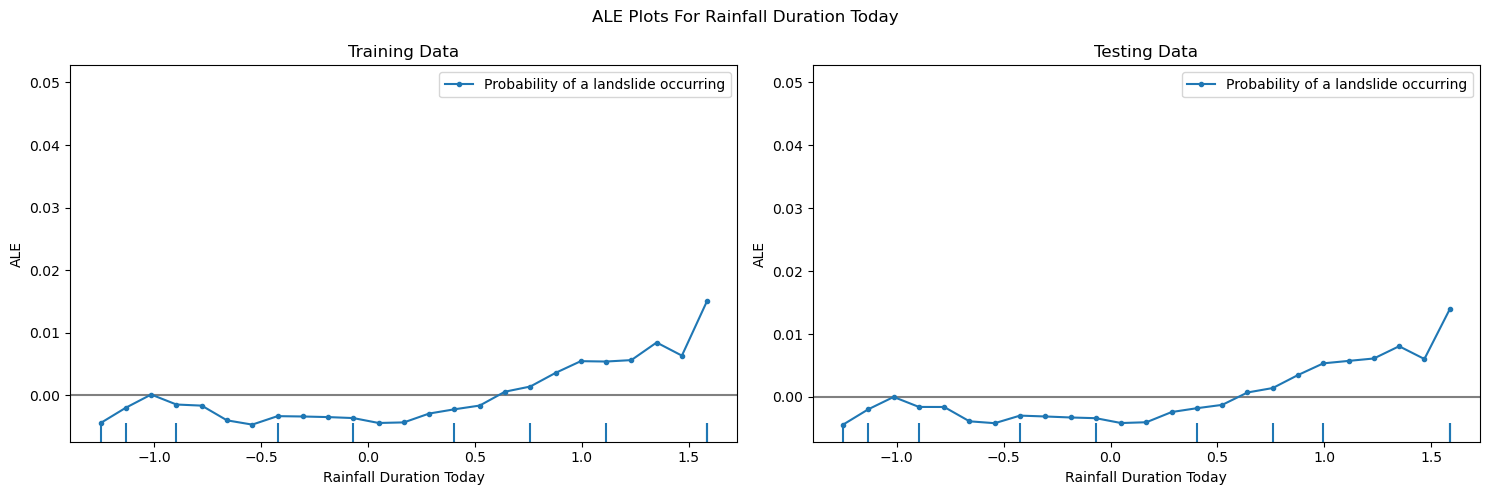

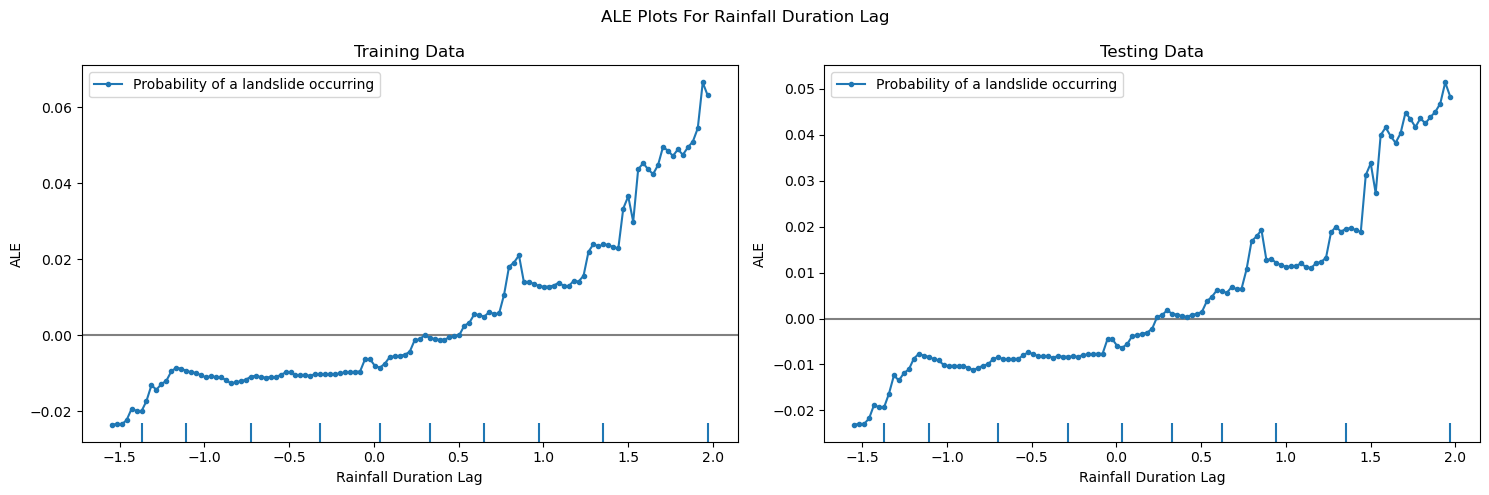

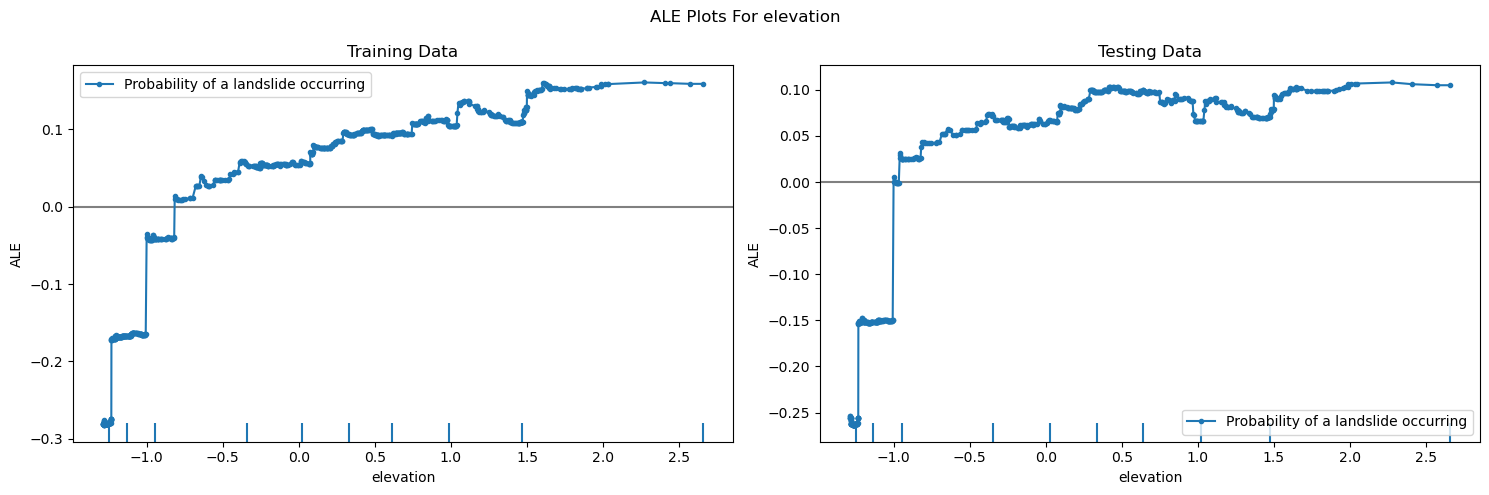

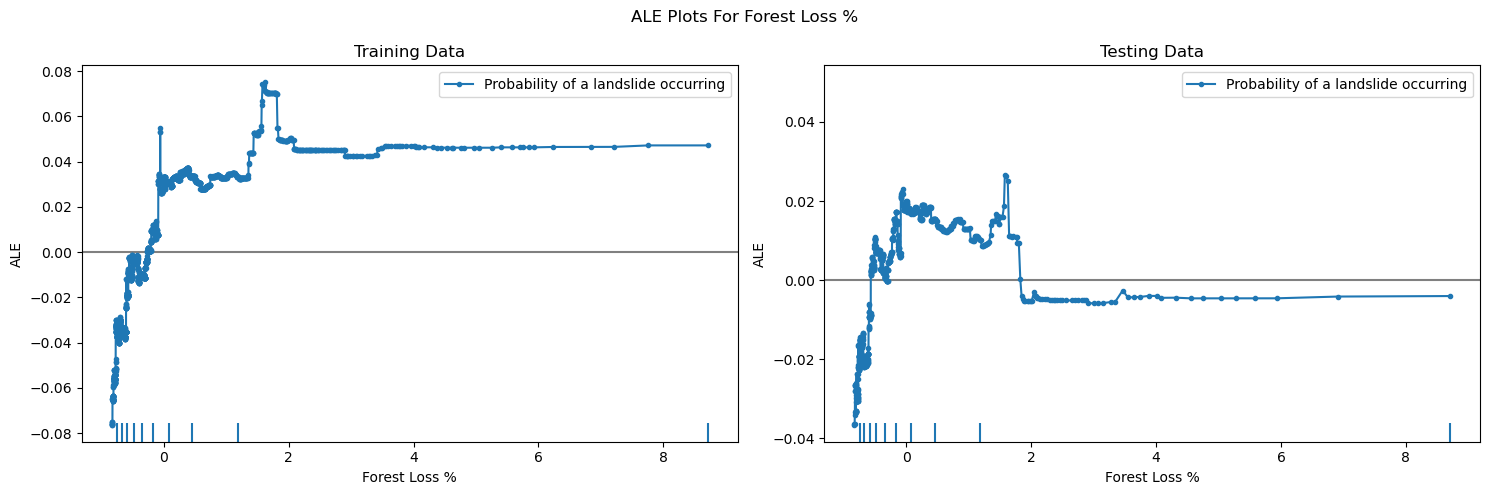

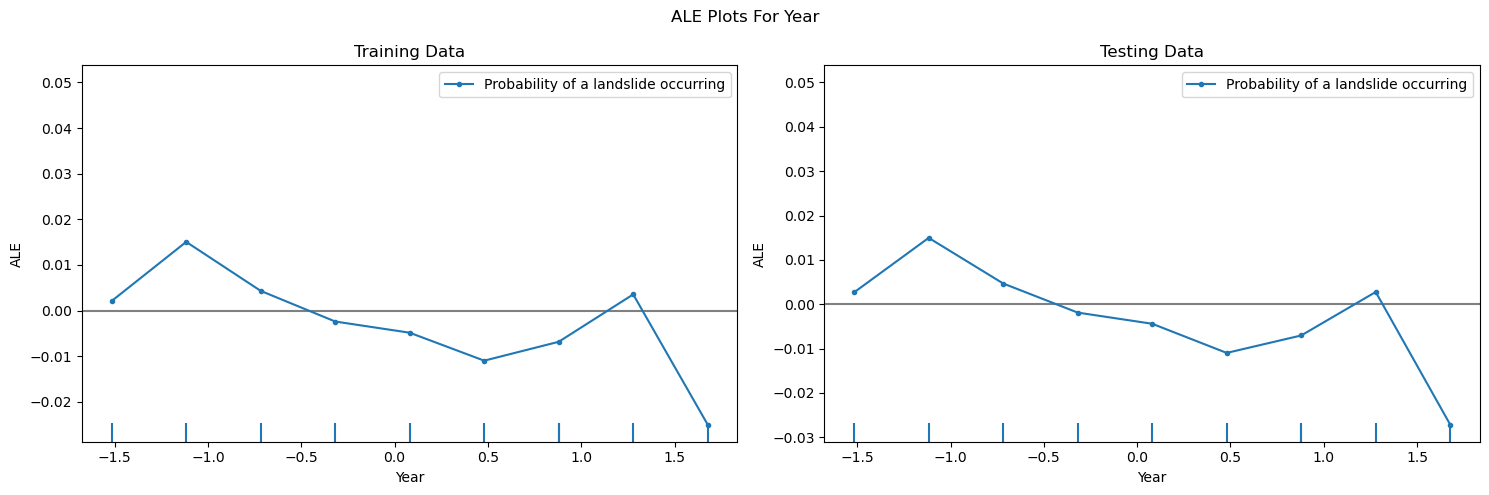

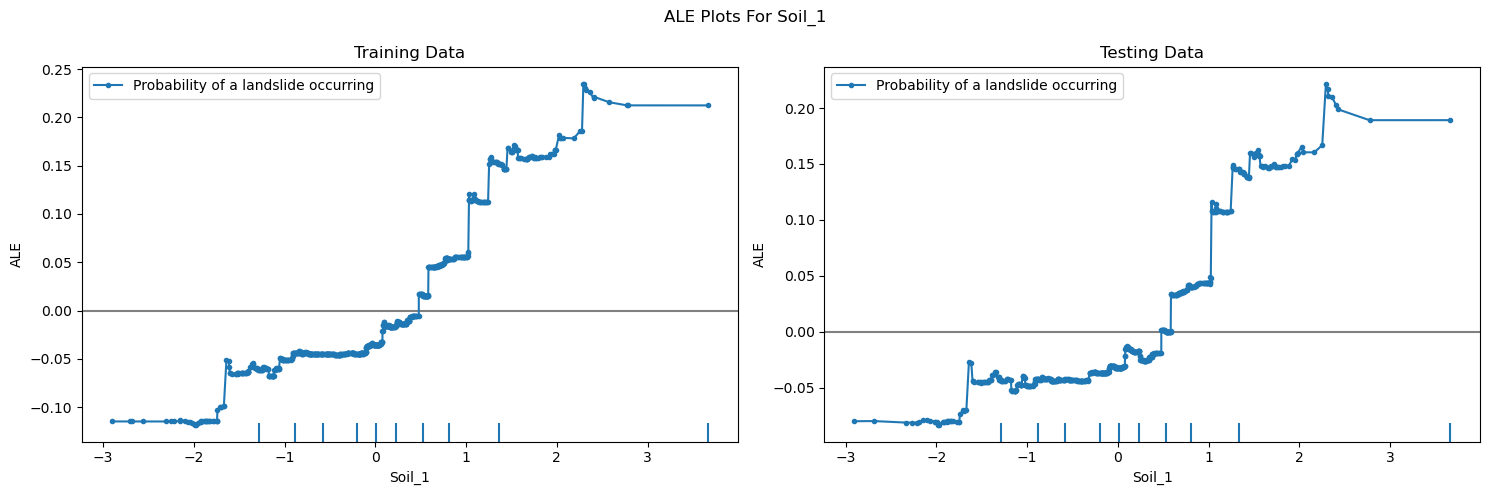

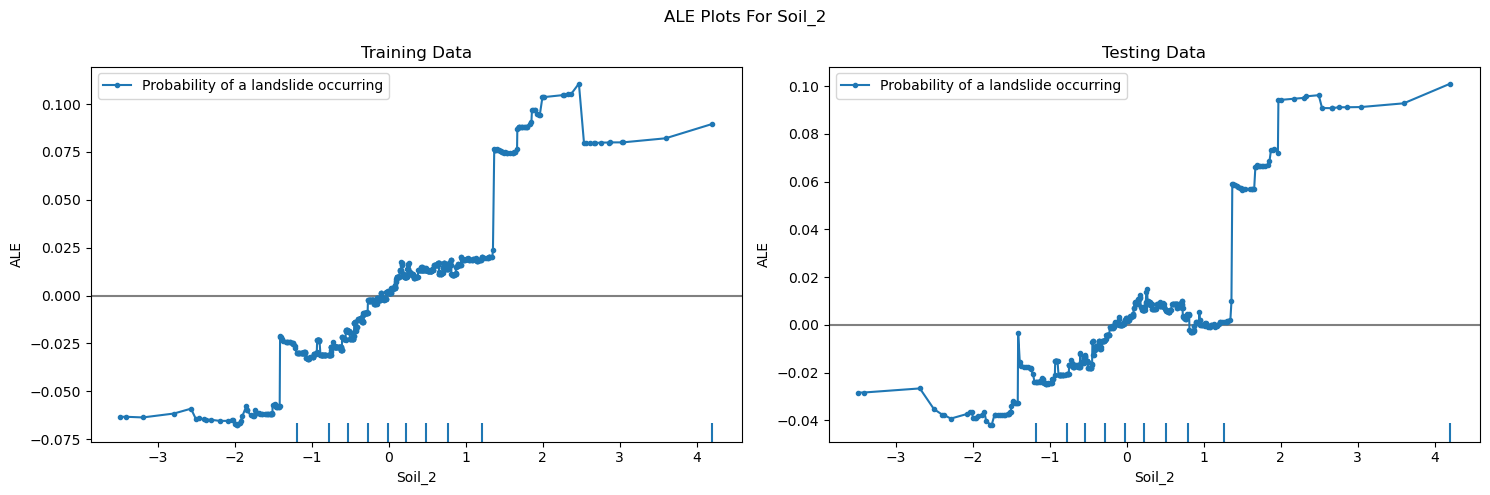

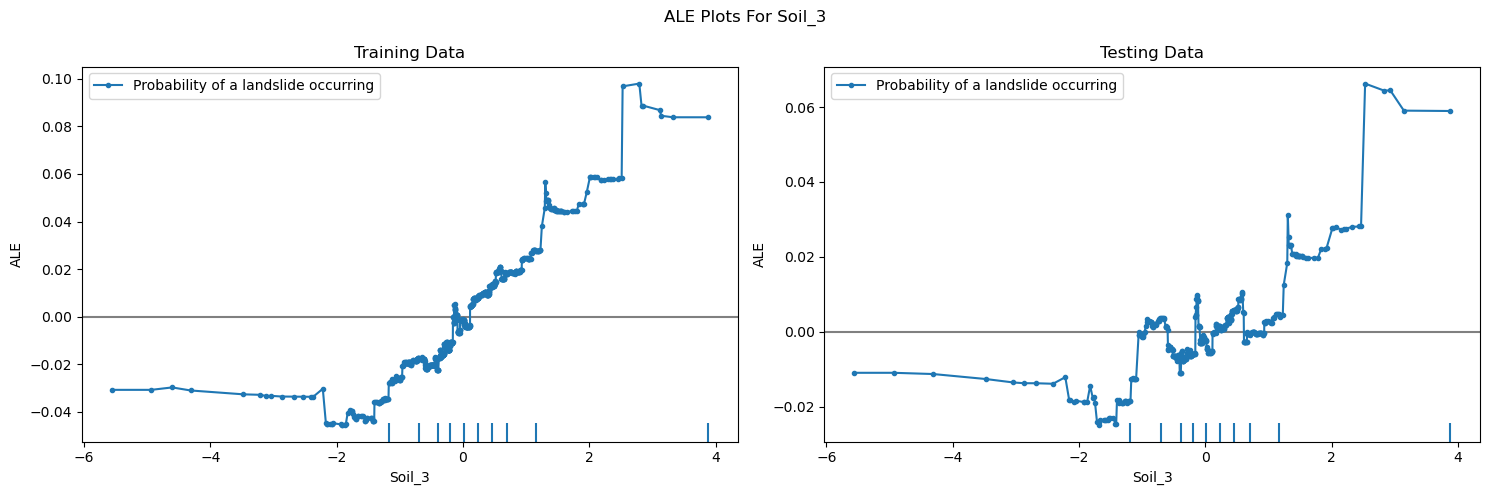

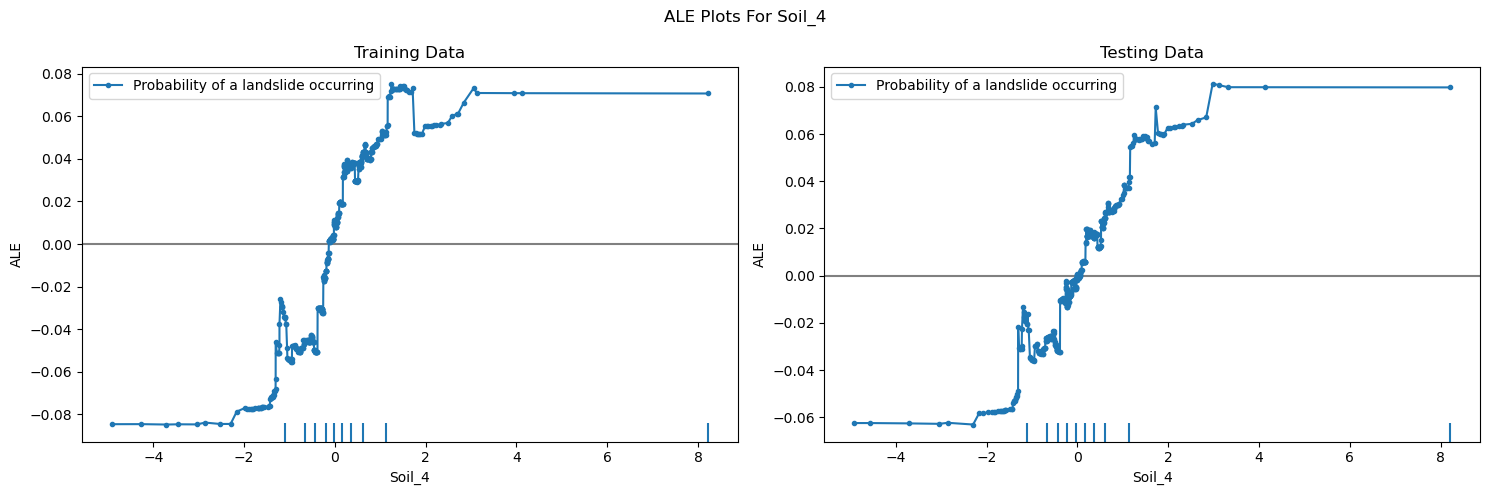

In [98]:
for feature in feature_cols:
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    fig.suptitle("ALE Plots For {}".format(feature))
    
    plot_ale(exp_train, features=[feature], line_kw={'label': 'Probability of a landslide occurring'}, ax = ax[0])
    ax[0].set_title("Training Data")
    
    plot_ale(exp_test, features=[feature], line_kw={'label': 'Probability of a landslide occurring'}, ax = ax[1])
    ax[1].set_title("Testing Data")
    
    plt.show()